In [ ]:
#---connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#---set working directory
import os
os.chdir('/content/drive/My Drive/KENYA') #--change directory
os.getcwd() #--check whether has been set correctly

'/content/drive/My Drive/KENYA'

In [ ]:
#---install pym depencies
!pip install mapclassify
!pip install rasterio
!pip install contextily
!pip install numpyro
!pip install arviz
!pip install fiona
!pip install rioxarray

In [ ]:
#--imports
from PIL import Image
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import folium
import contextily as ctx
import geopandas as gpd
import mapclassify
import rasterio as rio
from pyproj import Transformer
from rasterio.transform import xy
from rasterio.mask import mask
import fiona
import matplotlib.pyplot as plt
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import Affine
from shapely.ops import unary_union
from scipy.spatial import cKDTree
from sklearn.preprocessing import MinMaxScaler

# Data Processing

In [ ]:
#-------------------------------------------------------------------------------
#--data pre-processing
#-------------------------------------------------------------------------------
#--load data
try:
    kenya = pd.read_csv("pr_data.csv")
except FileNotFoundError:
    kenya = pd.read_csv(pm.get_data("pr_data.csv"))
kenya.head()

,longitude,latitude,total_tested,total_positive,prevalence
0,33.97000,0.10000,593,163.0,0.274874
1,33.99400,0.15800,171,117.0,0.684211
2,34.02000,-0.03000,237,51.0,0.215190
3,34.02000,0.22000,210,66.0,0.314286
4,34.05003,0.22096,110,56.0,0.509091


In [ ]:
#---convert total tested and positive to integer
kenya[["total_positive", "total_tested"]] = kenya[["total_positive", "total_tested"]].astype(int)# get metadata
kenya.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   longitude       1230 non-null   float64
 1   latitude        1230 non-null   float64
 2   total_tested    1230 non-null   int64  
 3   total_positive  1230 non-null   int64  
 4   prevalence      1230 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 48.2 KB



Extract Lake Region Malaria Endemic Counties
---

In [ ]:
#----level 1 admin  shapefile
admin1_gdf = gpd.read_file("/content/drive/My Drive/KENYA/ADM_KE/ken_admbnda_adm1_iebc_20191031.shp")

#---list of lake region malaria endemic counties
target_counties = ["Kisumu", "Siaya", "Homa Bay", "Migori", "Busia", "Vihiga", "Bungoma", "Kakamega"]

#---filter the selected counties
filtered_counties= admin1_gdf[admin1_gdf["ADM1_EN"].isin(target_counties)]

#---ensure CRS is in WGS84 (EPSG:4326) for compatibility
filtered_counties = filtered_counties.to_crs("EPSG:4326")


## Plot prevalence at survey locations
---

In [ ]:
#---create geodataframe of malaria prevalence data
#-----------------------------------------------------------------------------------------
prevalence_gdf = gpd.GeoDataFrame(
    kenya, geometry=gpd.points_from_xy(kenya["longitude"], kenya["latitude"]), crs="EPSG:4326"
)

#---assign each survey point to a county using spatial join
#-----------------------------------------------------------------------------------------
pr_gdf = prevalence_gdf.sjoin(filtered_counties, how="left", predicate="within")
counties_prev= pr_gdf[pr_gdf["ADM1_EN"].isin(target_counties)]
counties_prev=counties_prev[['longitude','latitude','ADM1_EN','total_tested',	'total_positive',	'prevalence',	'geometry']]


In [ ]:
#--total tested in the lake region counties
counties_prev['total_tested'].sum()

np.int64(57110)

In [ ]:
#---total positive
counties_prev['total_positive'].sum()

np.int64(19199)

In [ ]:
#---number of sampled locations
sampled_locations= counties_prev[['longitude','latitude']].drop_duplicates()
len(sampled_locations)

332

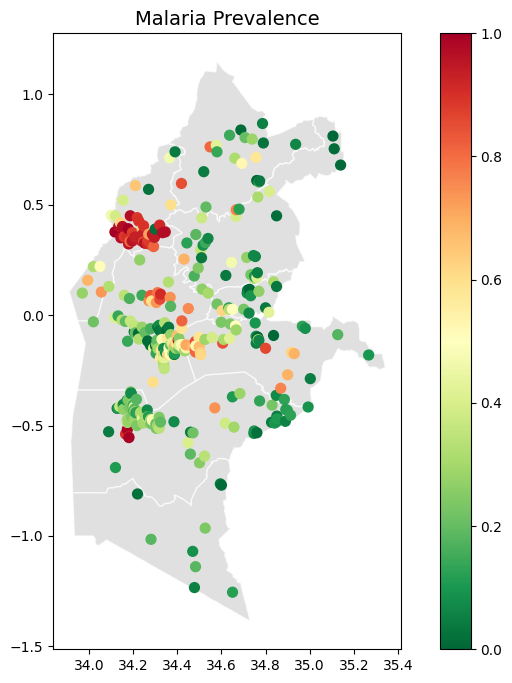

In [ ]:
#---plot the prevalence data
#----------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 8))
filtered_counties.plot(ax=ax, edgecolor="white", facecolor="lightgray", alpha=0.7)
counties_prev.plot(ax=ax, column="prevalence", cmap="RdYlGn_r", legend=True, markersize=50)
ax.set_title("Malaria Prevalence", fontsize=14)
plt.show()

# Create a polygony for clipping environmental covariates
---

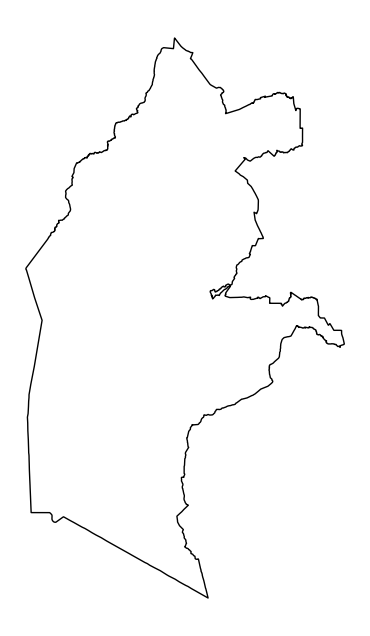

In [ ]:
#---merge into a single boundary
merged_boundary = unary_union(filtered_counties.geometry)

#---convert back to geopandas dataframe
merged_gdf = gpd.GeoDataFrame(geometry=[merged_boundary], crs=filtered_counties.crs)
merged_gdf=merged_gdf.to_crs('EPSG:32736')

#---save to new shapefile
merged_gdf.to_file("merged_boundary.shp")

#---plot
fig, ax = plt.subplots(figsize=(8, 8))
merged_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
ax.axis('off')
plt.show()

## Load and inspect environmental covariates raster files

In [ ]:

#---list of raster files
raster_files = [
    'Mean_Monthly_Temp_2022_ERA5_lake_region.tif',
    'mean_evi_2022_1km_lake_region.tif',
    'distance_to_water_2022_1km_lake_region.tif',
    'annual_precip_2022_1km_lake_region.tif'
]
#---loop over the files
for raster_path in raster_files:
    print(f"=== Raster File: {raster_path} ===")
    with rio.open(raster_path) as src:
        crs = src.crs
        resolution = src.res
        bounds = src.bounds
        nodata = src.nodata
        num_bands = src.count
        dtype = src.dtypes[0]

        #--- print meta data
        print(f"CRS: {crs}")
        print(f"Resolution: {resolution}")
        print(f"Extent (Bounds): {bounds}")
        print(f"NoData Value: {nodata}")
        print(f"Number of Bands: {num_bands}")
        print(f"Data Type: {dtype}")

        #--- check for missing raster values
        band1 = src.read(1)
        if nodata is not None:
            nodata_count = np.sum(band1 == nodata)
            print(f"Number of NoData pixels in band 1: {nodata_count}")
        else:
            print("NoData value is not defined.")
    print("\n" + "="*50 + "\n")


=== Raster File: Mean_Monthly_Temp_2022_ERA5_lake_region.tif ===
CRS: EPSG:32736
Resolution: (1000.0, 1000.0)
Extent (Bounds): BoundingBox(left=601000.0, bottom=9846000.0, right=761000.0, top=10128000.0)
NoData Value: None
Number of Bands: 1
Data Type: float64
NoData value is not defined.


=== Raster File: mean_evi_2022_1km_lake_region.tif ===
CRS: EPSG:32736
Resolution: (1000.0, 1000.0)
Extent (Bounds): BoundingBox(left=601000.0, bottom=9846000.0, right=761000.0, top=10128000.0)
NoData Value: None
Number of Bands: 1
Data Type: float64
NoData value is not defined.


=== Raster File: distance_to_water_2022_1km_lake_region.tif ===
CRS: EPSG:32736
Resolution: (1000.0, 1000.0)
Extent (Bounds): BoundingBox(left=601000.0, bottom=9846000.0, right=761000.0, top=10128000.0)
NoData Value: None
Number of Bands: 1
Data Type: float64
NoData value is not defined.


=== Raster File: annual_precip_2022_1km_lake_region.tif ===
CRS: EPSG:32736
Resolution: (1000.0, 1000.0)
Extent (Bounds): BoundingBox(l

## Extract covariate values and corresponding geocoordinates

In [ ]:
target_crs = 'EPSG:4326'
data = {}
coords = None
valid_indices = None

for i, path in enumerate(raster_files):
    with rio.open(path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)

        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        dest = np.empty((height, width), dtype=src.meta['dtype'])

        reproject(
            source=src.read(1),
            destination=dest,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest
        )

        nodata = src.nodata
        mask = dest != nodata if nodata is not None else ~np.isnan(dest)

        if coords is None:
            rows, cols = np.where(mask)
            xs, ys = rio.transform.xy(transform, rows, cols)
            coords = list(zip(xs, ys))
            valid_indices = (rows, cols)

        values = dest[valid_indices]
        name = path.replace('.tif', '').lower()
        data[name] = values

#---create dataframe
df = pd.DataFrame(data)
df['longitude'] = [x for x, y in coords]
df['latitude'] = [y for x, y in coords]
df = df[['longitude', 'latitude'] + list(data.keys())]



In [ ]:
df.head()

,longitude,latitude,mean_monthly_temp_2022_era5_lake_region,mean_evi_2022_1km_lake_region,distance_to_water_2022_1km_lake_region,annual_precip_2022_1km_lake_region
0,34.580274,1.153394,10.221369,0.229532,732.219060,1808.986875
1,34.580274,1.144365,9.634760,0.257006,740.939900,1825.492571
2,34.589302,1.144365,9.634760,0.253623,711.154691,1825.492571
3,34.580274,1.135336,9.634760,0.275370,750.875493,1825.492571
4,34.589302,1.135336,9.634760,0.240777,721.500617,1825.492571


In [ ]:
#--rename the columns
column_list = {
    'mean_evi_2022_1km_lake_region': 'EVI',
    'mean_monthly_temp_2022_era5_lake_region': 'Temp',
    'distance_to_water_2022_1km_lake_region': 'DistToWater',
    'annual_precip_2022_1km_lake_region': 'Precip'
}

df.rename(columns=column_list, inplace=True)

Normalize covariate values for improved numeical stability and prior consistency

In [ ]:
#---covariate columns (excluding 'longitude' and 'latitude')
covariate_cols = [col for col in df.columns if col not in ['longitude', 'EVI', 'latitude']]

#---initialize the scaler
scaler = MinMaxScaler()

#----fit and transform the covariates
df[covariate_cols] = scaler.fit_transform(df[covariate_cols])

In [ ]:
df.head()

,longitude,latitude,Temp,EVI,DistToWater,Precip
0,34.580274,1.153394,0.432888,0.229532,0.748124,0.641792
1,34.580274,1.144365,0.408044,0.257006,0.757034,0.647648
2,34.589302,1.144365,0.408044,0.253623,0.726602,0.647648
3,34.580274,1.135336,0.408044,0.275370,0.767185,0.647648
4,34.589302,1.135336,0.408044,0.240777,0.737172,0.647648


In [ ]:
df.describe()

,longitude,latitude,Temp,EVI,DistToWater,Precip
count,22935.000000,22935.000000,22935.000000,22935.000000,22935.000000,22935.000000
mean,34.487410,-0.096009,0.892225,0.317696,0.194047,0.659891
std,0.301265,0.581094,0.102593,0.153332,0.144242,0.108053
min,33.912138,-1.392746,0.000000,-0.041707,0.000000,0.000000
25%,34.255235,-0.525975,0.865173,0.330142,0.089031,0.590096
50%,34.489985,-0.110647,0.900227,0.381631,0.160756,0.660282
75%,34.697649,0.367883,0.956020,0.403477,0.259788,0.721490
max,35.338698,1.153394,1.000000,0.617353,1.000000,1.000000


In [ ]:
df.head()

## Perform nearest neighbor matching
Next we extract data for environmental predictors for locations for which we have prevalences. We use an optimized version of KDTree i.e cKDTree to perform the location matching.

In [ ]:

df_cov = df #--dataframe with environmental covariates

# ---extract raster coords
raster_coords = df_cov[['longitude', 'latitude']].values

#---build KDTree from raster coordinates
tree = cKDTree(raster_coords)

#---query nearest neighbors with counties_prev as target file
distances, indices = tree.query(counties_prev[['longitude', 'latitude']].values, k=1)

#---for each covariate column, match by index
covariate_vars = ['EVI','Temp','DistToWater','Precip']

for var in covariate_vars:
    matched_values = df_cov[var].values[indices]
    counties_prev[var] = matched_values
    counties_prev[f"{var}_long"] = raster_coords[indices][:, 0]
    counties_prev[f"{var}_lat"] = raster_coords[indices][:, 1]

#---save the result as csv
counties_prev.to_csv("counties_with_covariates.csv", index=False)


In [ ]:
counties_with_covariates=pd.read_csv("counties_with_covariates.csv")
counties_with_covariates.head()

,longitude,latitude,ADM1_EN,total_tested,total_positive,prevalence,geometry,EVI,EVI_long,EVI_lat,Temp,Temp_long,Temp_lat,DistToWater,DistToWater_long,DistToWater_lat,Precip,Precip_long,Precip_lat
0,33.97000,0.10000,Busia,593,163,0.274874,POINT (33.97 0.1),0.266081,33.966311,0.097017,0.956020,33.966311,0.097017,0.032040,33.966311,0.097017,0.497948,33.966311,0.097017
1,33.99400,0.15800,Busia,171,117,0.684211,POINT (33.994 0.158),0.301212,33.993398,0.160219,0.943381,33.993398,0.160219,0.103498,33.993398,0.160219,0.608439,33.993398,0.160219
2,34.02000,-0.03000,Siaya,237,51,0.215190,POINT (34.02 -0.03),0.406418,34.020484,-0.029387,0.972281,34.020484,-0.029387,0.106494,34.020484,-0.029387,0.497704,34.020484,-0.029387
3,34.02000,0.22000,Busia,210,66,0.314286,POINT (34.02 0.22),0.370785,34.020484,0.223421,0.943381,34.020484,0.223421,0.028872,34.020484,0.223421,0.590149,34.020484,0.223421
4,34.05003,0.22096,Busia,110,56,0.509091,POINT (34.05003 0.22096),0.421011,34.047571,0.223421,0.943381,34.047571,0.223421,0.062347,34.047571,0.223421,0.591212,34.047571,0.223421


In [ ]:
#---modeling variables and parameters
evi=counties_with_covariates["EVI"].values
temp = counties_with_covariates["Temp"].values
precip = counties_with_covariates["Precip"].values
dist = counties_with_covariates["DistToWater"].values
pos = counties_with_covariates["total_positive"].values
n = counties_with_covariates["total_tested"].values
lonlat =counties_with_covariates[["longitude", "latitude"]].values

In [ ]:
#---set seed for reproducebility
seed: int = sum(map(ord, "spatialmalaria"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# Model Specification

We specify the following model:
$$Y_{i} \sim Binomial(n_{i}, P(x_{i}))$$
$$logit(P(x_{i})) = \beta_{0} + \beta_{1}evi +\beta_{2}temp +\beta_{3}precip +\beta_{4}dist  + S(x_{i})$$

Where $n_{i}$ represents an individual tested for malaria, $P(x_{i})$ is the prevalence of malaria at location $x_{i}$, $\beta_{0}$ is the intercept, $\beta_{i}$ are the cofficients for environmental covariates and $S(x_{i})$ is a zero mean field gaussian process with a Matérn covariance function with $\nu=\frac{3}{2}$ that we will approximate using a Hilbert Space Gaussian Process (HSGP)

In order to approximate a Gaussian process using an HSGP we need to select the parameters `m` and `c`. To learn more about how to set these parameters please refer to this wonderful ([example](../gaussian_processes/HSGP-Basic.myst.md)) of how to set these parameters.

In [ ]:
with pm.Model() as hsgp_model:
    #---spatial coordinates
    _X = pm.Data("X", lonlat)

    #---predictors
    _evi = pm.Data("evi", evi)
    _temp = pm.Data("temp", temp)
    _precip = pm.Data("precip", precip)
    _dist = pm.Data("dist", dist)

    #---GP covariance and hyperparameters
    ls = pm.Gamma("ls", mu=20, sigma=5)
    cov_func = pm.gp.cov.Matern32(2, ls=ls)
    m0, m1, c = 40, 40, 2.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    s = gp.prior("s", X=_X)

    #---regression coefficients
    beta_0 = pm.Normal("beta_0", 0, 1)
    beta_1 = pm.Normal("beta_1", 0, 1)  #---evi
    beta_2 = pm.Normal("beta_2", 0, 1)  #---temp
    beta_3 = pm.Normal("beta_3", 0, 1)  #---precip
    beta_4 = pm.Normal("beta_4", 0, 1)  #---dist

    #---linear predictor incorporating all predictors plus the spatial effect
    p_logit = pm.Deterministic("p_logit",
                              beta_0 + beta_1 * _evi + beta_2 * _temp + beta_3 * _precip + beta_4 * _dist+ s)
    p = pm.Deterministic("p", pm.math.invlogit(p_logit))

    #---likelihood: assuming a binomial model (with n trials, observed successes pos)
    pm.Binomial("likelihood", n=n, logit_p=p_logit, observed=pos)


## Graphical representation of the model

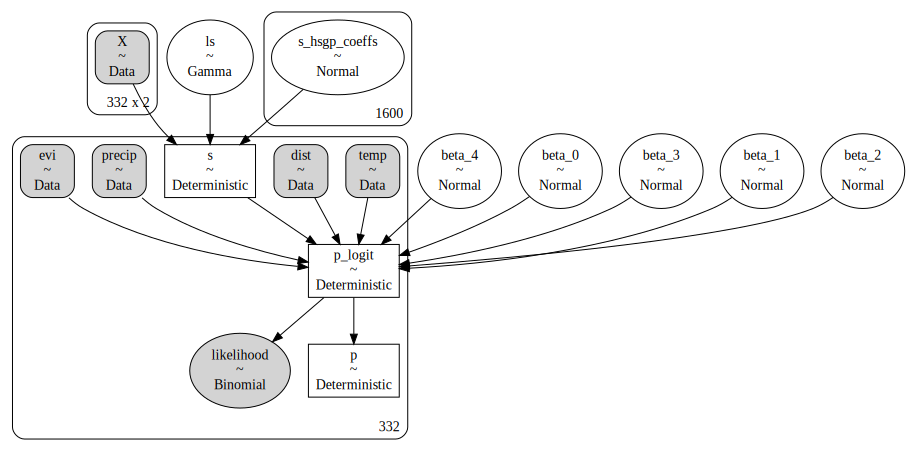

In [ ]:
hsgp_model.to_graphviz()

In [ ]:
with hsgp_model:
    hsgp_trace = pm.sample(
        500, tune=500, target_accept=0.95, nuts_sampler="numpyro", random_seed=rng
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

 The posterior mean of the length scale is 0.2 (shown below). Therefore, we can expect the gaussian mean to decay towards 0 (since we set a 0 mean function) as we move 0.2 degrees away from any sampled point on the map. While this is not a hard cut-off due to the lengthscale not being constrained by the observed data it is still useful to be able to intuit how the lengthscale effects the estimation.

In [ ]:
az.summary(hsgp_trace, var_names=["ls"], kind="stats") #default is 94% can set to hdi_prob=0.95

,mean,sd,hdi_3%,hdi_97%
ls,0.052,0.002,0.049,0.055


# Posterior Predictive Checks

We need to validate that our model specification properly represents the observed data. We can push out posterior predictions of the prevalence and plot them on a coordinate system to check if they resemble the observed prevalence from our sample

In [ ]:
with hsgp_model:
    ppc = pm.sample_posterior_predictive(hsgp_trace, random_seed=rng)

Output()

In [ ]:
posterior_prevalence = hsgp_trace["posterior"]["p"]

we can see that our posterior predictions in the figure below on the left agree with the observed sample shown on the right.

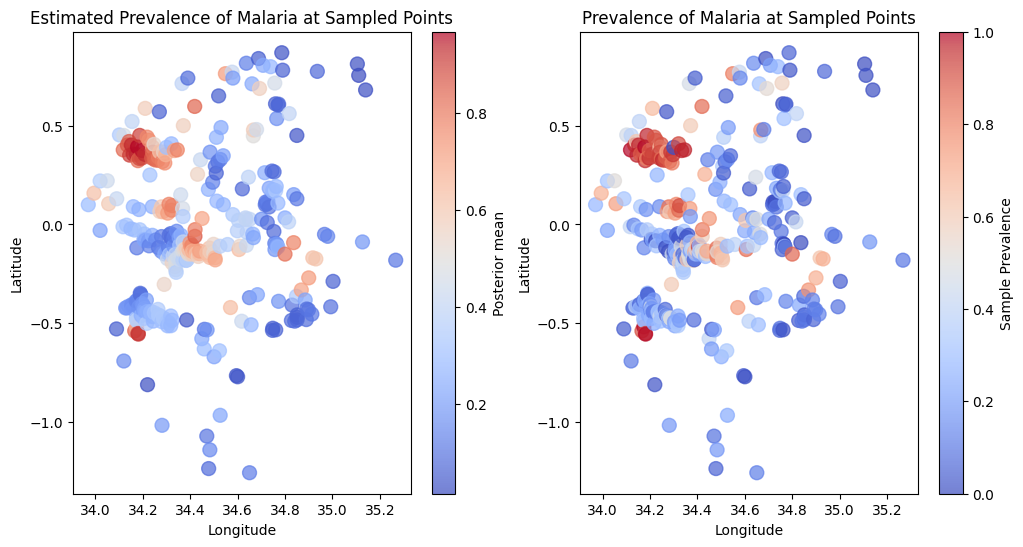

In [ ]:
plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.scatter(
    lonlat[:, 0],
    lonlat[:, 1],
    c=posterior_prevalence.mean(("chain", "draw")),
    marker="o",
    alpha=0.7,
    s=100,
    cmap="coolwarm",
    edgecolor=None,
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Estimated Prevalence of Malaria at Sampled Points")
plt.colorbar(label="Posterior mean")

plt.subplot(1, 2, 2)

plt.scatter(
    lonlat[:, 0],
    lonlat[:, 1],
    c=counties_prev["prevalence"],
    marker="o",
    alpha=0.7,
    s=100,
     cmap="coolwarm",
    edgecolor=None,
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Prevalence of Malaria at Sampled Points")
plt.colorbar(label="Sample Prevalence");

We can also check if the likelihood (number of individuals who test positive for malaria) agrees with the observed data. As you can see in the below figure, our posterior predictive sample is representative of the observed sample.

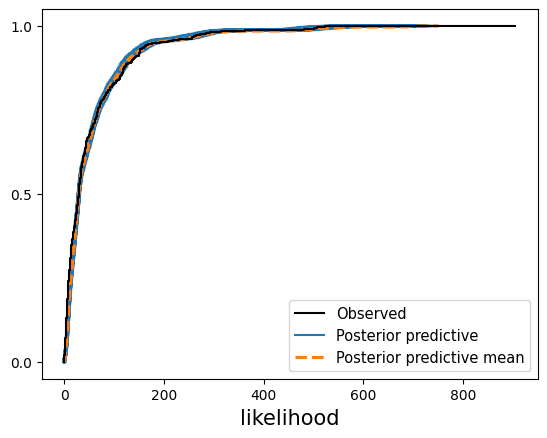

In [ ]:
az.plot_ppc(ppc, kind="cumulative");

# Out-of-sample posterior predictions

Now that we have validated that we have a representative model that converged, we want to estimate the prevalence of malaria in the surrounding areas to where we have observed data points. Our new dataset will include every longitude and latitude position within the Gambia where we have a measure of elevation.

In [ ]:
#---coordinates and covariates for out-of sample prediction
new_lonlat = df[["longitude", "latitude"]].to_numpy()
new_evi = df["EVI"].to_numpy()
new_temp = df["Temp"].to_numpy()
new_precip = df["Precip"].to_numpy()
new_dist = df["DistToWater"].to_numpy()

#---perform posterior prediction
with hsgp_model:
    pm.set_data(new_data={
        "X": new_lonlat,
        "evi": new_evi,
        "temp": new_temp,
        "precip": new_precip,
        "dist": new_dist
    })

    pp = pm.sample_posterior_predictive(hsgp_trace, var_names=["p"], random_seed=rng)


Output()

In [ ]:
posterior_predictive_prevalence = pp["posterior_predictive"]["p"]

We can plot our out-of-sample posterior predictions to visualize the estimated prevalence of malaria across the Gambia. In figure below you'll notice that there is a smooth transition of prevalences surrounding the areas where we observed data in a way where nearer areas have more similar prevalences and as you move away you approach zero (the mean of the gaussian process).

# Making decisions based on exceedance probabilities

One way to determine where we might decide to apply interventions is to look at exceedance probabilities of some selected threshold of malaria prevalence. These exeedance probabilities will allow us to incorporate our uncertainty in the prevalences we have estimated instead of just considering the mean of the posterior distribution. For our use case, we decide to set an exceedance threshold of 30% on the prevalance.

We can use the insights gained from the figure below to send out aid to the regions where we are most confident that the prevalence of malaria exceeds 30%.

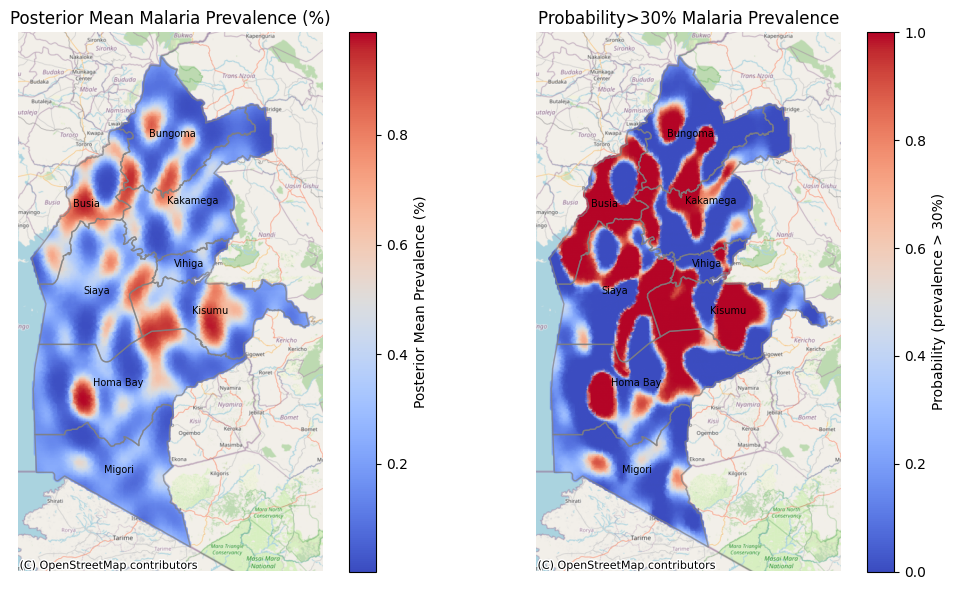

In [ ]:
# --- posterior summaries
posterior_mean = posterior_predictive_prevalence.mean(("chain", "draw")).values
prob_prev_exceed_30 = 1 - (posterior_predictive_prevalence <= 0.3).mean(("chain", "draw")).values

# --- geodataframe
points_geom = [Point(xy) for xy in new_lonlat]
gdf_prevalence = gpd.GeoDataFrame({"prevalence": posterior_mean}, geometry=points_geom, crs="EPSG:4326")
gdf_prob_exceed = gpd.GeoDataFrame({"prevalence": prob_prev_exceed_30}, geometry=points_geom, crs="EPSG:4326")

# --- reproject filtered_counties
filtered_counties = filtered_counties.to_crs("EPSG:4326")

# --- merge and clip
merged_boundary = filtered_counties.union_all()
merged_gdf = gpd.GeoDataFrame(geometry=[merged_boundary], crs="EPSG:4326")

clipped_prevalence = gpd.clip(gdf_prevalence, merged_gdf).to_crs(epsg=3857)
clipped_prob_exceed = gpd.clip(gdf_prob_exceed, merged_gdf).to_crs(epsg=3857)
filtered_counties_proj = filtered_counties.to_crs(epsg=3857)

# --- combined plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6), sharey=True)

# --- plot posterior mean prevalence
sc1 = clipped_prevalence.plot(
    ax=ax1,
    column="prevalence",
    cmap="coolwarm",
    markersize=5,
    alpha=0.5,
    legend=True,
    legend_kwds={"label": "Posterior Mean Prevalence (%)"}
)
filtered_counties_proj.boundary.plot(ax=ax1, color="grey", linewidth=1, alpha=0.7)
for _, row in filtered_counties_proj.iterrows():
    centroid = row.geometry.centroid
    ax1.text(centroid.x, centroid.y, row["ADM1_EN"], fontsize=7, color="black", ha="center", va="center")
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
ax1.set_axis_off()
ax1.set_title("Posterior Mean Malaria Prevalence (%)")

# --- plot probability of exceedance
sc2 = clipped_prob_exceed.plot(
    ax=ax2,
    column="prevalence",
    cmap="coolwarm",
    markersize=5,
    alpha=0.5,
    legend=True,
    legend_kwds={"label": "Probability (prevalence > 30%)"}
)
filtered_counties_proj.boundary.plot(ax=ax2, color="grey", linewidth=1, alpha=0.7)
for _, row in filtered_counties_proj.iterrows():
    centroid = row.geometry.centroid
    ax2.text(centroid.x, centroid.y, row["ADM1_EN"], fontsize=7, color="black", ha="center", va="center")
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_axis_off()
ax2.set_title("Probability>30% Malaria Prevalence")

# ---
plt.tight_layout()

# ---save the fig
fig.savefig("malaria_prevalence.png", dpi=300, bbox_inches="tight")

# ---
plt.show()


# Model with covariates VS null model

In [ ]:
#-------------------------------------------------------------------------------
#--full model
#-------------------------------------------------------------------------------
with pm.Model() as full_model:
    # Data
    _X = pm.Data("X", lonlat)
    _evi = pm.Data("evi", evi)
    _temp = pm.Data("temp", temp)
    _precip = pm.Data("precip", precip)
    _dist = pm.Data("dist", dist)

    # GP
    ls = pm.Gamma("ls", mu=20, sigma=5)
    cov_func = pm.gp.cov.Matern32(2, ls=ls)
    gp = pm.gp.HSGP(m=[40, 40], c=2.5, cov_func=cov_func)
    s = gp.prior("s", X=_X)

    #--coefficients
    beta_0 = pm.Normal("beta_0", 0, 1)
    beta_1 = pm.Normal("beta_1", 0, 1)
    beta_2 = pm.Normal("beta_2", 0, 1)
    beta_3 = pm.Normal("beta_3", 0, 1)
    beta_4 = pm.Normal("beta_4", 0, 1)

    p_logit = pm.Deterministic("p_logit",
        beta_0 + beta_1 * _evi + beta_2 * _temp + beta_3 * _precip + beta_4 * _dist + s
    )
    p = pm.Deterministic("p", pm.math.invlogit(p_logit))

    pm.Binomial("likelihood", n=n, logit_p=p_logit, observed=pos)


In [ ]:
with full_model:
    hsgp_trace_full = pm.sample(
        500, tune=500,
        target_accept=0.95,
        nuts_sampler="numpyro",
        random_seed=rng,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
with pm.Model() as null_model:
    #---data
    _X = pm.Data("X", lonlat)

    #---GP
    ls = pm.Gamma("ls", mu=20, sigma=5)
    cov_func = pm.gp.cov.Matern32(2, ls=ls)
    gp = pm.gp.HSGP(m=[40, 40], c=2.5, cov_func=cov_func)
    s = gp.prior("s", X=_X)
    beta_0 = pm.Normal("beta_0", 0, 1)
    p_logit = pm.Deterministic("p_logit", beta_0 + s)
    p = pm.Deterministic("p", pm.math.invlogit(p_logit))
    pm.Binomial("likelihood", n=n, logit_p=p_logit, observed=pos)


In [ ]:
with null_model:
    hsgp_trace_null = pm.sample(
        500, tune=500,
        target_accept=0.95,
        nuts_sampler="numpyro",
        random_seed=rng,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
az.summary(hsgp_trace_null, var_names=["ls"], kind="stats")

,mean,sd,hdi_3%,hdi_97%
ls,0.053,0.002,0.05,0.056


In [ ]:
az.summary(hsgp_trace_full, var_names=["ls"], kind="stats")

,mean,sd,hdi_3%,hdi_97%
ls,0.052,0.002,0.049,0.056


            rank    elpd_waic       p_waic  elpd_diff    weight          se  \
Full model     0 -3558.360647  1226.220927   0.000000  0.623896  341.770004   
Null model     1 -3569.285805  1232.224577  10.925158  0.376104  343.157515   

                  dse  warning scale  
Full model   0.000000     True   log  
Null model  19.571001     True   log  


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

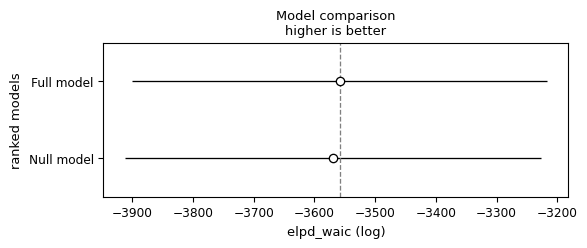

In [ ]:
waic_results = az.compare(
    {"Full model": hsgp_trace_full, "Null model": hsgp_trace_null},
    ic="waic"
)

print(waic_results)
az.plot_compare(waic_results)

In [ ]:
az.compare({"Full model":hsgp_trace_full , "Null model": hsgp_trace_null}, ic="loo")

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Full model,0,-3377.176220,1045.036501,0.000000,0.605866,274.568594,0.00000,True,log
Null model,1,-3387.029085,1049.967858,9.852865,0.394134,272.708898,19.14145,True,log


In [ ]:
import pymc as pm
import numpy as np
import aesara.tensor as at

with pm.Model() as spatial_stacked_model:

    # --- Data
    X_stack_data = pm.Data("X_stack", X_stack)  # shape (n, 3)
    coords = pm.Data("coords", lonlat)          # shape (n, 2)
    N = pm.Data("N", n)                          # total sample sizes
    Y = pm.Data("Y", y)                          # observed counts

    # --- Constrained weights: softmax ensures sum-to-one and positivity
    raw_beta = pm.Normal("raw_beta", mu=0, sigma=1, shape=X_stack.shape[1])
    beta = pm.Deterministic("beta", at.softmax(raw_beta))

    # --- Intercept
    intercept = pm.Normal("intercept", mu=0, sigma=1)

    # --- Linear term (weighted combination of stacked covariates)
    linear_part = intercept + at.sum(beta * X_stack_data, axis=1)

    # --- Nugget effect (independent noise)
    sigma_nug = pm.HalfNormal("sigma_nug", sigma=1.0)
    nugget = pm.Normal("nugget", mu=0, sigma=sigma_nug, shape=X_stack.shape[0])

    # --- Spatial Gaussian Process (using Matérn covariance)
    ls = pm.Gamma("length_scale", mu=1.0, sigma=1.0)
    cov_func = pm.gp.cov.Matern32(input_dim=2, ls=ls)

    gp = pm.gp.Latent(cov_func=cov_func)
    omega = gp.prior("omega", X=coords)

    # --- Logit link
    logit_p = linear_part + omega + nugget
    p = pm.Deterministic("p", pm.math.invlogit(logit_p))

    # --- Binomial likelihood
    pm.Binomial("likelihood", n=N, p=p, observed=Y)

    # --- Sampling
    trace = pm.sample(1000, tune=1000, chains=4, target_accept=0.95)


# Conclusion

The case-study walked us through how we can utilize an HSGP to include spatial information into our estimates. Specifically, we saw how we can validate our model specification, produce out-of-sample estimates, and how we can use the whole posterior distribution to make decisions.

## Authors

* Adapted from {ref}`Geospatial Health Data: Modeling and Visualization with R-INLA and Shiny` by Dr. Paula Moraga ([link](https://www.paulamoraga.com/book-geospatial/index.html)).
### Acknowledgments
* Bill Engels who encouraged, reviewed, and provided both feedback and code improvements to this example
* Osvaldo A Martin, reviewed and provided valuable feedback that improved the example